# Code

In [1]:
from plot_setup import * 
import MCgenerator, dSph_model, coord

In [2]:
prms = {
    "re":r"$r_e[\mathrm{pc}]$",
    "sigmafg":r"\tilde{\Sigma}_\mathrm{FG}"
}
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [3]:
SPECIFY_NAME = "refR-re-w-center_sersic"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
# v001: for mycut
# v002: for spectroscopy cut

In [13]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.sersic_model(re_pc=200,n=4)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,n,odds,dra0,dde0):
        return np.sum(self.loglikelis(re,n,odds,dra0,dde0))
    def loglikelis(self,re,n,odds,dra0,dde0):
        if re<0 or odds<0 or n<0.5 or 10<n:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re,"n":n})
            ref_R = self.mem.half_light_radius() # 1.67834699001666*re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            #print("mem.density2d:",mem.density_2d(ref_R))
            #print("mem.mean_density2d:",mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [5]:
class KI17_loglikelihood:
    def __init__(self,Rs):
        self.Rs = Rs
        self.RoI_R = np.max(Rs) # use Rs.max as the RoI
        print(self.Rs)
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def __call__(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            loglikelis = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return np.sum(loglikelis)
    def loglikelis(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            ret = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return ret
    def s_to_odds(self,s,ref_R):
        mem,fg = self.mem,self.fg
        return mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R)/(1/s-1)

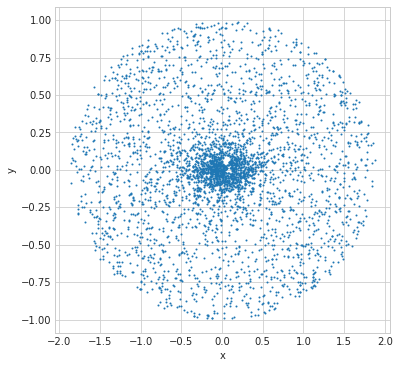

In [6]:
df0 = np.loadtxt("Draco_SDSS_cut_xy1.0.csv",comments="#",delimiter=",")
df_deg = pd.DataFrame(df0,columns=("x","y"))
df_rad = np.deg2rad(pd.DataFrame(df0,columns=("x","y")))

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.x + RA0
de = df_deg.y + DE0


arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 1
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb398f53978>]],
      dtype=object)

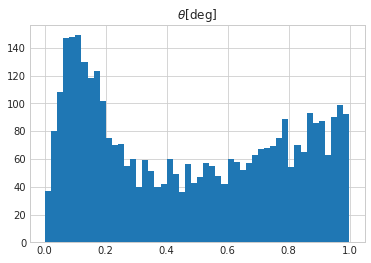

In [7]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb398ea5198>]],
      dtype=object)

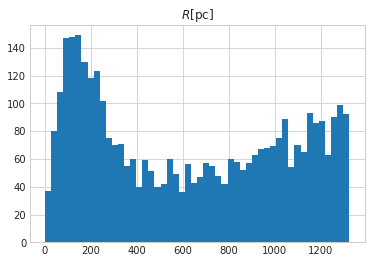

In [8]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

## definition of likelihood

In [14]:
loglikeli = KI17_loglikelihood_mod(dRAs=df_deg.x[angles<1.0],dDEs=df_deg.y[angles<1.0])
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

count    3655.000000
mean      625.164179
std       421.068471
min         1.698731
25%       211.871502
50%       596.463856
75%      1023.876544
max      1325.086262
dtype: float64


In [15]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={"re":150,"n":1, "odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [16]:
gen.logpdf_func.mem.cdf_R(gen.logpdf_func.Rs(0,0))

0       0.981562
1       0.999435
2       0.999806
3       0.992942
4       0.998773
5       0.999989
6       0.998413
7       0.998725
8       0.999484
9       0.983473
10      0.993853
11      0.999854
12      0.999836
13      0.699360
14      0.689767
15      0.348699
16      0.437954
17      0.385643
18      0.045524
19      0.406505
20      0.689338
21      0.498205
22      0.678969
23      0.365618
24      0.502310
25      0.112356
26      0.137698
27      0.956736
28      0.889082
29      0.974799
          ...   
3625    0.999993
3626    0.990930
3627    0.999993
3628    0.999957
3629    0.999960
3630    0.987038
3631    0.998937
3632    0.878399
3633    0.009016
3634    0.885329
3635    0.999847
3636    0.615189
3637    0.272609
3638    0.996255
3639    0.929980
3640    0.144535
3641    0.999988
3642    0.999969
3643    0.999967
3644    0.999988
3645    0.999646
3646    0.981689
3647    0.999983
3648    0.999990
3649    0.982871
3650    0.999504
3651    0.999943
3652    0.4021

In [17]:
Nstep_init = 5000
gen.generate(Nstep_init)

MCgeneration start.
options: {}
64.900% completed... acceptance rate: 10.76%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0    n  odds   re  iter_num
0  0.01  0.01  0.1   0.5  5.0      5000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb398a61da0>,
      dtype=object)

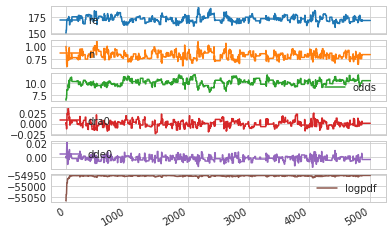

In [18]:
gen.to_DataFrame().plot(subplots=True)

In [19]:
gen.generate_tuned((5000,5000,5000))

MCgeneration start.
options: {}
63.660% completed... acceptance rate: 10.84%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0    n  odds   re  iter_num
0  0.01  0.01  0.1   0.5  5.0      5000
1  0.01  0.01  0.1   0.5  5.0      5000
0th iteration: update dargs_logpdf. 
before:
re      5.00
n       0.10
odds    0.50
dra0    0.01
dde0    0.01
dtype: float64
after:
re      4.858124
n       0.065018
odds    0.628653
dra0    0.006785
dde0    0.003425
dtype: float64
MCgeneration start.
options: {}
64.580% completed... acceptance rate: 23.88%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       dde0      dra0         n      odds        re  iter_num
0  0.010000  0.010000  0.100000  0.500000  5.000000      5000
1  0.010000  0.010000  0.100000  0.500000  5.000000      5000
2  0.003425  0.006785  0.065018  0.628653  4.858124      5000
1th iteration: update dargs_logpdf. 
before:
re      4.858124
n       0.065018
odds    0.628653
dra0    0.006785
dde0    0.00342

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3988721d0>,
      dtype=object)

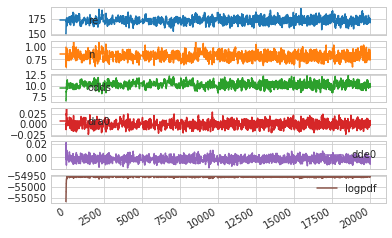

In [20]:
gen.to_DataFrame()[:].plot(subplots=True)

In [21]:
gen.options["push_time"] = 30
gen.generate(200000)

MCgeneration start.
options: {'push_time': 30}
4.812% completed... acceptance rate: 23.02%
9.640% completed... acceptance rate: 23.21%
14.461% completed... acceptance rate: 23.14%
19.270% completed... acceptance rate: 23.23%
24.092% completed... acceptance rate: 23.43%
28.914% completed... acceptance rate: 23.52%
33.697% completed... acceptance rate: 23.43%
38.510% completed... acceptance rate: 23.48%
43.319% completed... acceptance rate: 23.48%
48.118% completed... acceptance rate: 23.44%
52.953% completed... acceptance rate: 23.45%
57.781% completed... acceptance rate: 23.41%
62.601% completed... acceptance rate: 23.40%
67.356% completed... acceptance rate: 23.46%
72.184% completed... acceptance rate: 23.55%
76.972% completed... acceptance rate: 23.54%
81.373% completed... acceptance rate: 23.47%
85.842% completed... acceptance rate: 23.45%
90.304% completed... acceptance rate: 23.48%
95.037% completed... acceptance rate: 23.51%
99.668% completed... acceptance rate: 23.51%
MCgenerati

## results

In [ ]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

if you already done the calculation, load the result below.

In [ ]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

print last 200000 steps


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb394651860>,
      dtype=object)

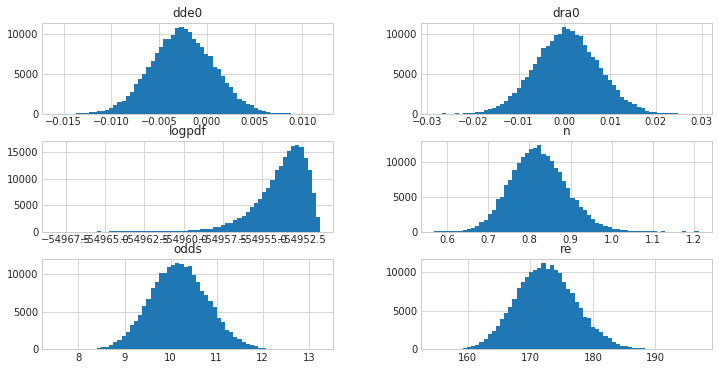

In [26]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

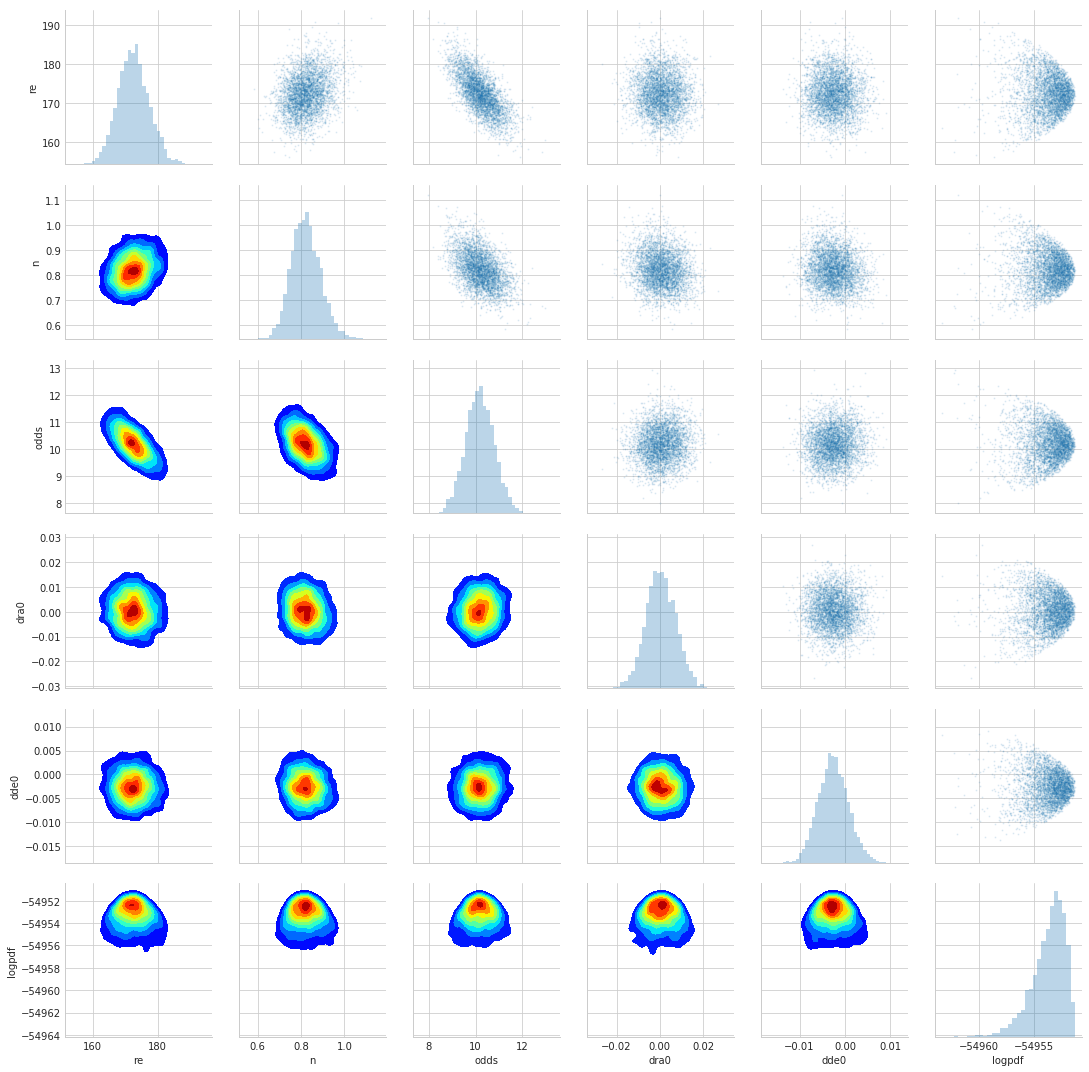

In [27]:
mypairplot(result_df[-last_MCMC_steps::50])
#mypairplot(result_df[-lastMCMCsteps])

In [28]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

,re,n,odds,dra0,dde0,logpdf
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,172.532687,0.822203,10.187345,0.000554,-0.002530,-54953.755074
std,4.798839,0.067285,0.618790,0.006929,0.003279,1.552770
min,154.598740,0.568306,7.499360,-0.028500,-0.015847,-54968.161814
16%,167.787257,0.755477,9.570395,-0.006348,-0.005777,-54955.207715
50%,172.409473,0.819694,10.178043,0.000534,-0.002566,-54953.440056
84%,177.284889,0.888359,10.807232,0.007475,0.000762,-54952.317984
max,196.891710,1.210330,13.247416,0.029332,0.011859,-54951.326715


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3955e08d0>],
      dtype=object)

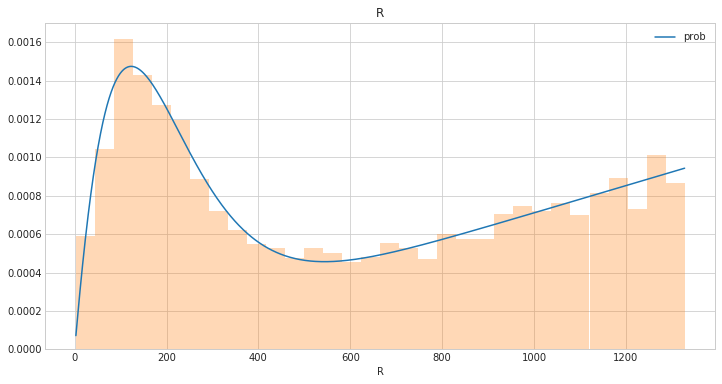

In [30]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

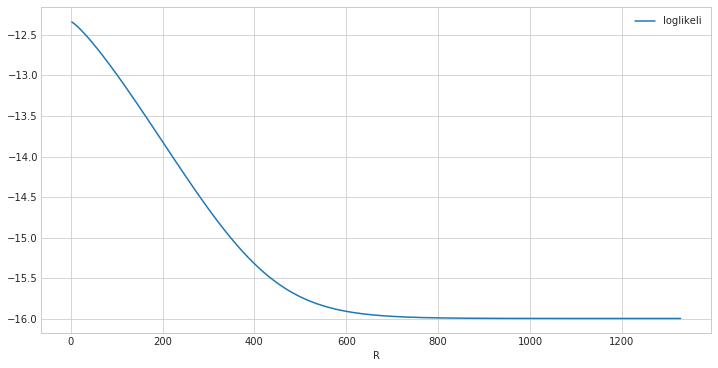

In [31]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME
version = VERSION
result_df.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)

# WBIC calculation

In [ ]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            return np.sum(self.loglikelis(re,odds,dra0,dde0))
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [32]:
loglikeli_wbic = KI17_loglikelihood_mod(dRAs=df_deg.x,dDEs=df_deg.y,beta=1/np.log(len(df_deg)))

count    3655.000000
mean      625.164179
std       421.068471
min         1.698731
25%       211.871502
50%       596.463856
75%      1023.876544
max      1325.086262
dtype: float64
beta: 0.12189396840983949


In [33]:
gen_wbic = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"n":0.8,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli_wbic
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [34]:
gen_wbic.generate(5000)

MCgeneration start.
options: {}
66.020% completed... acceptance rate: 51.01%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0    n  odds   re  iter_num
0  0.01  0.01  0.1   0.5  5.0      5000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb395446ac8>,
      dtype=object)

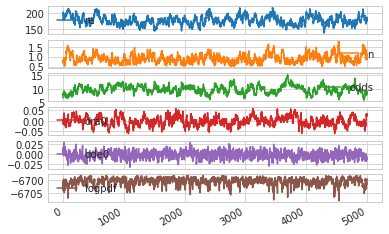

In [35]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [36]:
gen_wbic.generate_tuned((5000,5000,5000))

MCgeneration start.
options: {}
64.520% completed... acceptance rate: 52.08%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0    n  odds   re  iter_num
0  0.01  0.01  0.1   0.5  5.0      5000
1  0.01  0.01  0.1   0.5  5.0      5000
0th iteration: update dargs_logpdf. 
before:
re      5.00
n       0.10
odds    0.50
dra0    0.01
dde0    0.01
dtype: float64
after:
re      15.858284
n        0.205537
odds     1.686476
dra0     0.020484
dde0     0.009563
dtype: float64
MCgeneration start.
options: {}
69.560% completed... acceptance rate: 23.55%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       dde0      dra0         n      odds         re  iter_num
0  0.010000  0.010000  0.100000  0.500000   5.000000      5000
1  0.010000  0.010000  0.100000  0.500000   5.000000      5000
2  0.009563  0.020484  0.205537  1.686476  15.858284      5000
1th iteration: update dargs_logpdf. 
before:
re      15.858284
n        0.205537
odds     1.686476
dra0     0.020484
dd

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3952dc4a8>,
      dtype=object)

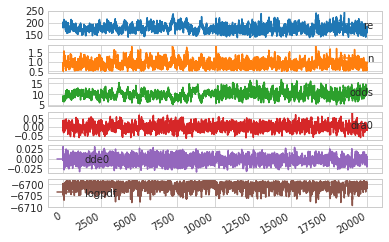

In [37]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [38]:
gen_wbic.generate(100000)

MCgeneration start.
options: {}
3.473% completed... acceptance rate: 21.54%
6.886% completed... acceptance rate: 22.09%
10.394% completed... acceptance rate: 22.52%
13.920% completed... acceptance rate: 22.26%
17.465% completed... acceptance rate: 21.88%
20.982% completed... acceptance rate: 21.43%
24.499% completed... acceptance rate: 21.47%
28.010% completed... acceptance rate: 21.41%
31.515% completed... acceptance rate: 21.38%
34.977% completed... acceptance rate: 21.47%
38.405% completed... acceptance rate: 21.59%
42.031% completed... acceptance rate: 21.58%
45.505% completed... acceptance rate: 21.58%
48.893% completed... acceptance rate: 21.49%
52.377% completed... acceptance rate: 21.47%
55.880% completed... acceptance rate: 21.38%
59.369% completed... acceptance rate: 21.49%
62.816% completed... acceptance rate: 21.49%
66.293% completed... acceptance rate: 21.45%
69.757% completed... acceptance rate: 21.45%
73.193% completed... acceptance rate: 21.42%
76.636% completed... acce

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

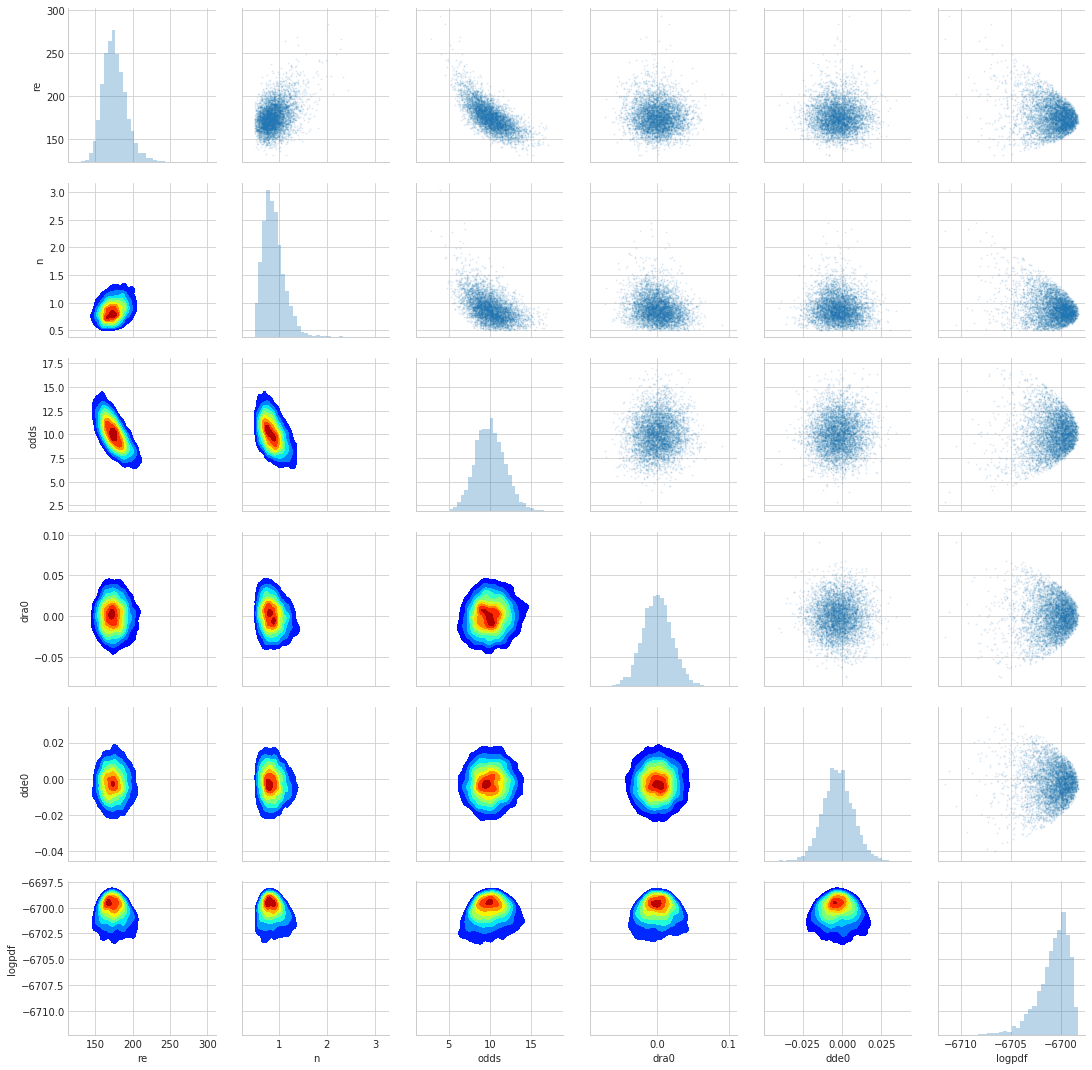

In [39]:
df_wbic = gen_wbic.to_DataFrame()[-100000:]
df_wbiclog = gen_wbic.to_DataFrame(output_log=True)
mypairplot(df_wbic[::20])

In [ ]:
wbic = -df_wbic.logpdf.mean()/loglikeli_wbic.beta
bic = -gen.to_DataFrame()[-100000:].logpdf.max() + len(gen.args_logpdf_init)/loglikeli_wbic.beta /2
print(" BIC:{}\nWBIC:{}".format(bic,wbic))

In [40]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME+"_wbic"
version = VERSION
df_wbic.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)